# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
sb.set()

# Importing the Dataset

In [2]:
data = pd.read_csv('ks-projects-201801.csv')
data.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


# Cleaning the Dataset

In [6]:
data.dropna(subset = ['name'], inplace=True)
clean_data = data.copy()
clean_data['state'] = clean_data['state'].replace(['canceled', 'suspended'], 'failed')
clean_data = clean_data.drop_duplicates('name', keep='last')
clean_data = clean_data.drop(['ID','pledged','currency','usd pledged'],axis=1)
clean_data = clean_data[clean_data['state'] != 'undefined']
clean_data = clean_data[clean_data['state'] != 'live']
clean_data.head()

,name,category,main_category,deadline,goal,launched,state,backers,country,usd_pledged_real,usd_goal_real
0,The Songs of Adelaide & Abullah,Poetry,Publishing,2015-10-09,1000.0,2015-08-11 12:12:28,failed,0,GB,0.0,1533.95
1,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,2017-11-01,30000.0,2017-09-02 04:43:57,failed,15,US,2421.0,30000.00
2,Where is Hank?,Narrative Film,Film & Video,2013-02-26,45000.0,2013-01-12 00:20:50,failed,3,US,220.0,45000.00
3,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,2012-04-16,5000.0,2012-03-17 03:24:11,failed,1,US,1.0,5000.00
4,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,2015-08-29,19500.0,2015-07-04 08:35:03,failed,14,US,1283.0,19500.00


In [83]:
# sb.catplot(y = "state", data = clean_data, kind = "count")
failed['usd_goal_real'].describe()

count      236397.00
mean        66052.87
std       1440502.17
min             0.01
25%          2700.00
50%          7713.00
75%         22269.98
max     166361390.71
Name: usd_goal_real, dtype: float64

# Creation of new variables for EDA

In [43]:
clean_launched = pd.to_datetime(clean_data['launched'])
clean_deadline = pd.to_datetime(clean_data['deadline'])
duration = clean_deadline - clean_launched

clean_data['duration'] = duration.dt.days
clean_data['launch_month'] = clean_launched.dt.month
clean_data['launch_year'] = clean_launched.dt.year

clean_data = clean_data[clean_data['launch_year'] != 1970]

clean_data['name_length'] = clean_data['name'].str.len()

clean_data['pledge_per_backer'] = pd.DataFrame(clean_data['usd_pledged_real'] / clean_data['backers'])
clean_data['pledge_per_backer'] = clean_data['pledge_per_backer'].fillna(0)

failed = clean_data[clean_data.state == 'failed']
successful = clean_data[clean_data.state == 'successful']

# Basic EDA

In [62]:
print("SUCCESS STATS:")
pd.set_option('display.float_format', lambda x: '%.2f' % x)
print(successful.usd_goal_real.describe())

print()

print("FAILURE STATS:")
pd.set_option('display.float_format', lambda x: '%.2f' % x)
print(failed.usd_goal_real.describe())

SUCCESS STATS:
count    133088.00
mean       9552.80
std       28033.84
min           0.01
25%        1319.39
50%        3859.22
75%       10000.00
max     2015608.88
Name: usd_goal_real, dtype: float64

FAILURE STATS:
count      236397.00
mean        66052.87
std       1440502.17
min             0.01
25%          2700.00
50%          7713.00
75%         22269.98
max     166361390.71
Name: usd_goal_real, dtype: float64


In [36]:
print("Average goal amount in USD\n")
print("Failed (USD) : ", failed['usd_goal_real'].mean())
print("Successful (USD) : ", successful['usd_goal_real'].mean())

print("\nAverage pledged amount in USD\n")
print("Failed (USD) : ", failed['usd_pledged_real'].mean())
print("Successful (USD) : ", successful['usd_pledged_real'].mean())

Average goal amount in USD

Failed (USD) :  66051.07049089693
Successful (USD) :  9552.797650802477

Average pledged amount in USD

Failed (USD) :  1549.8790561496423
Successful (USD) :  22744.237115292137


In [61]:
print("Average duration in Days\n")
print("Failed (Days) : ", failed['duration'].mean())
print("Successful (Days) : ", successful['duration'].mean())

Average duration in Days

Failed (Days) :  34.31095995296049
Successful (Days) :  31.16973731666266


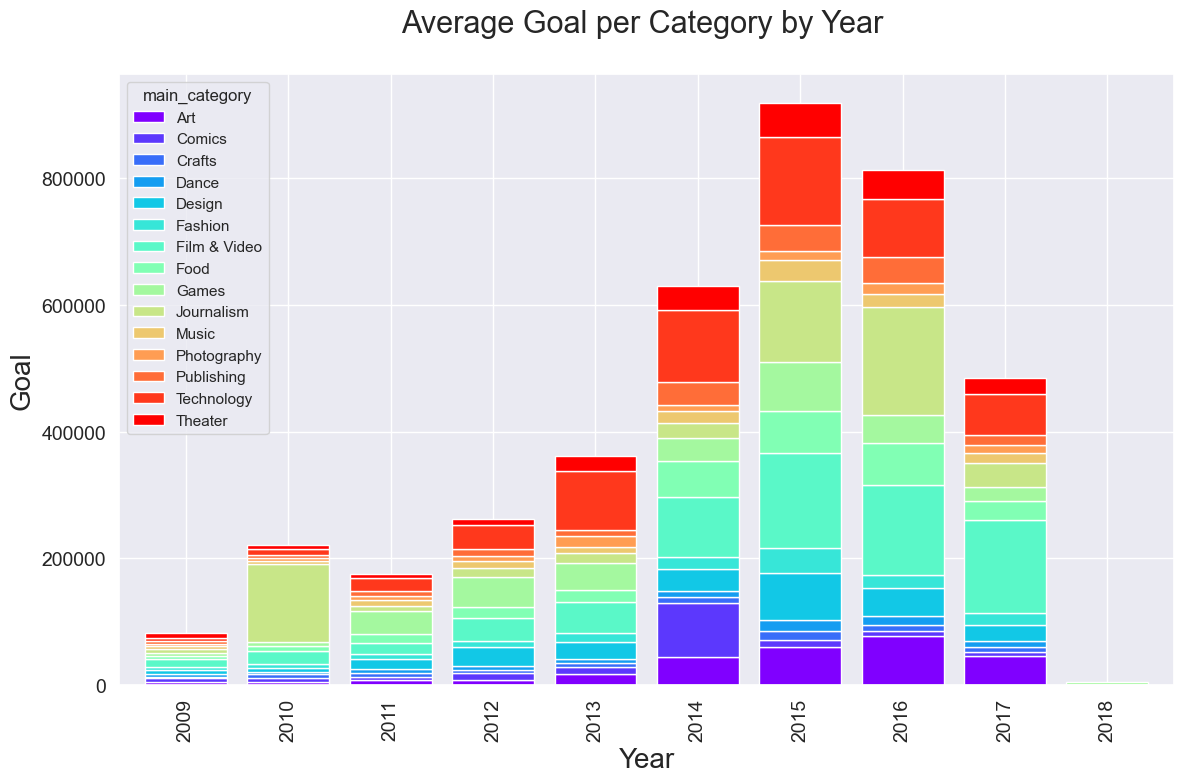

In [44]:
ax = plt.subplot(111)
clean_data.groupby(['launch_year', 'main_category'])['usd_goal_real'].mean().unstack().plot(kind = 'bar',
                                                                                      figsize=(12,8), stacked=True, width=0.8, colormap='rainbow',ax=ax)

plt.title('Average Goal per Category by Year \n', fontsize=22)
plt.xlabel('Year', fontsize=20)
plt.ylabel('Goal', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Main Category vs usd_pledge_real \n')

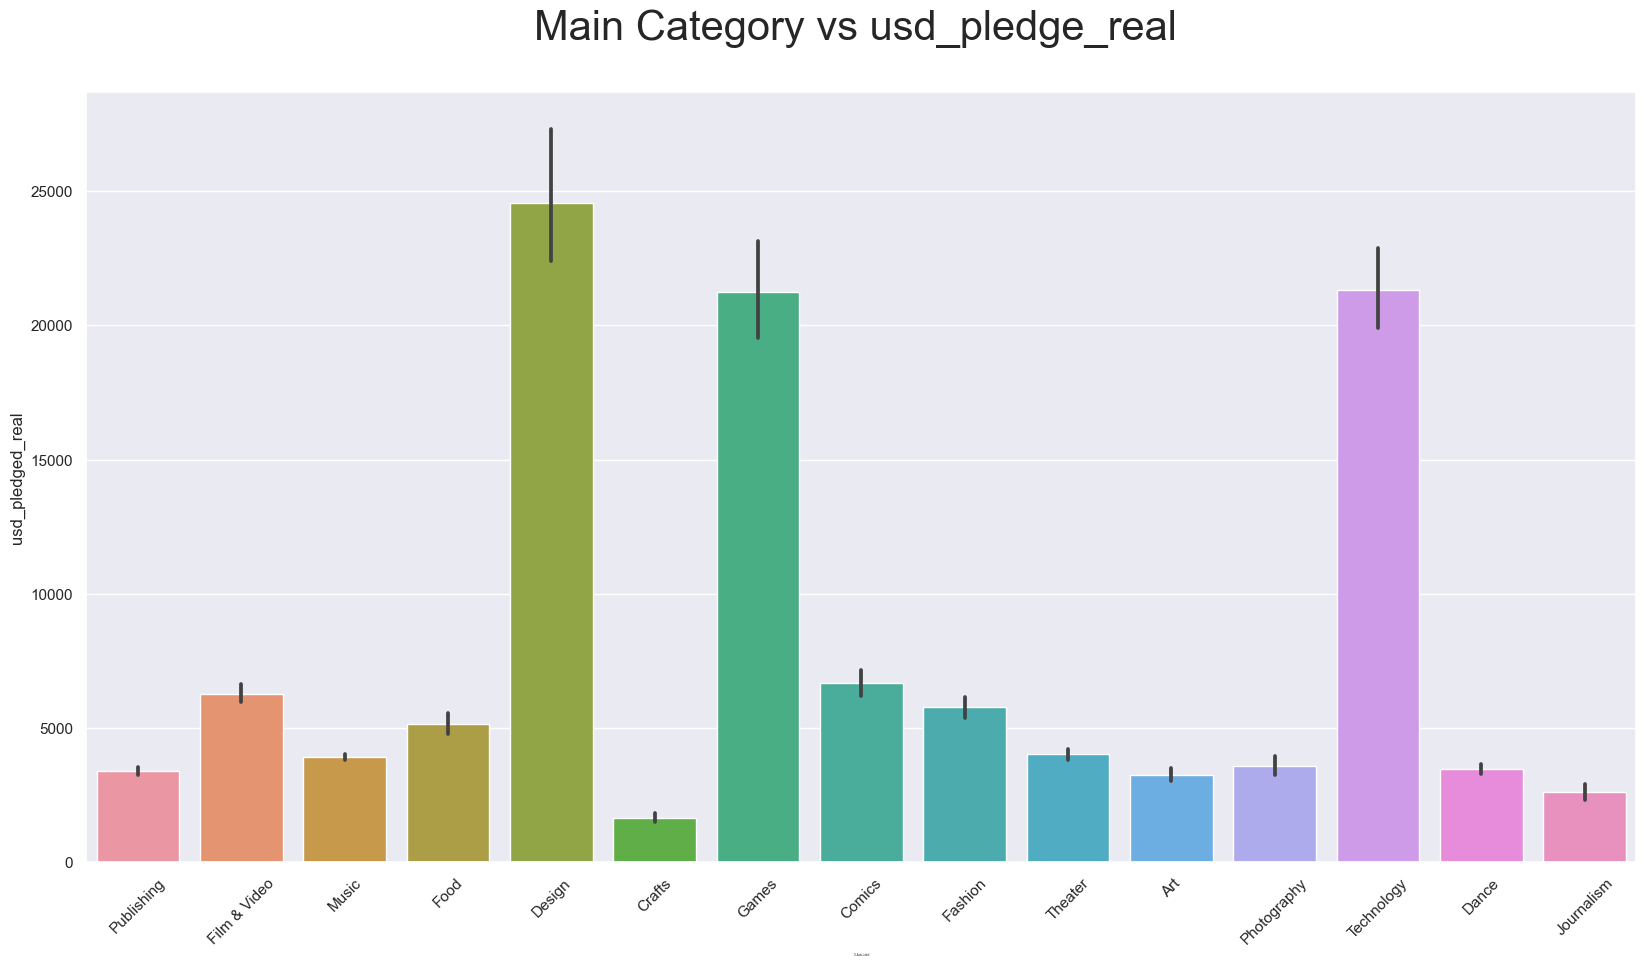

In [98]:
sb.barplot(x=clean_data["main_category"], y=clean_data["usd_pledged_real"])
plt.xlabel('X-Axis Label' ,fontsize=2)
plt.xticks(rotation=45)
plt.title('Main Category vs usd_pledge_real \n', fontsize=30)

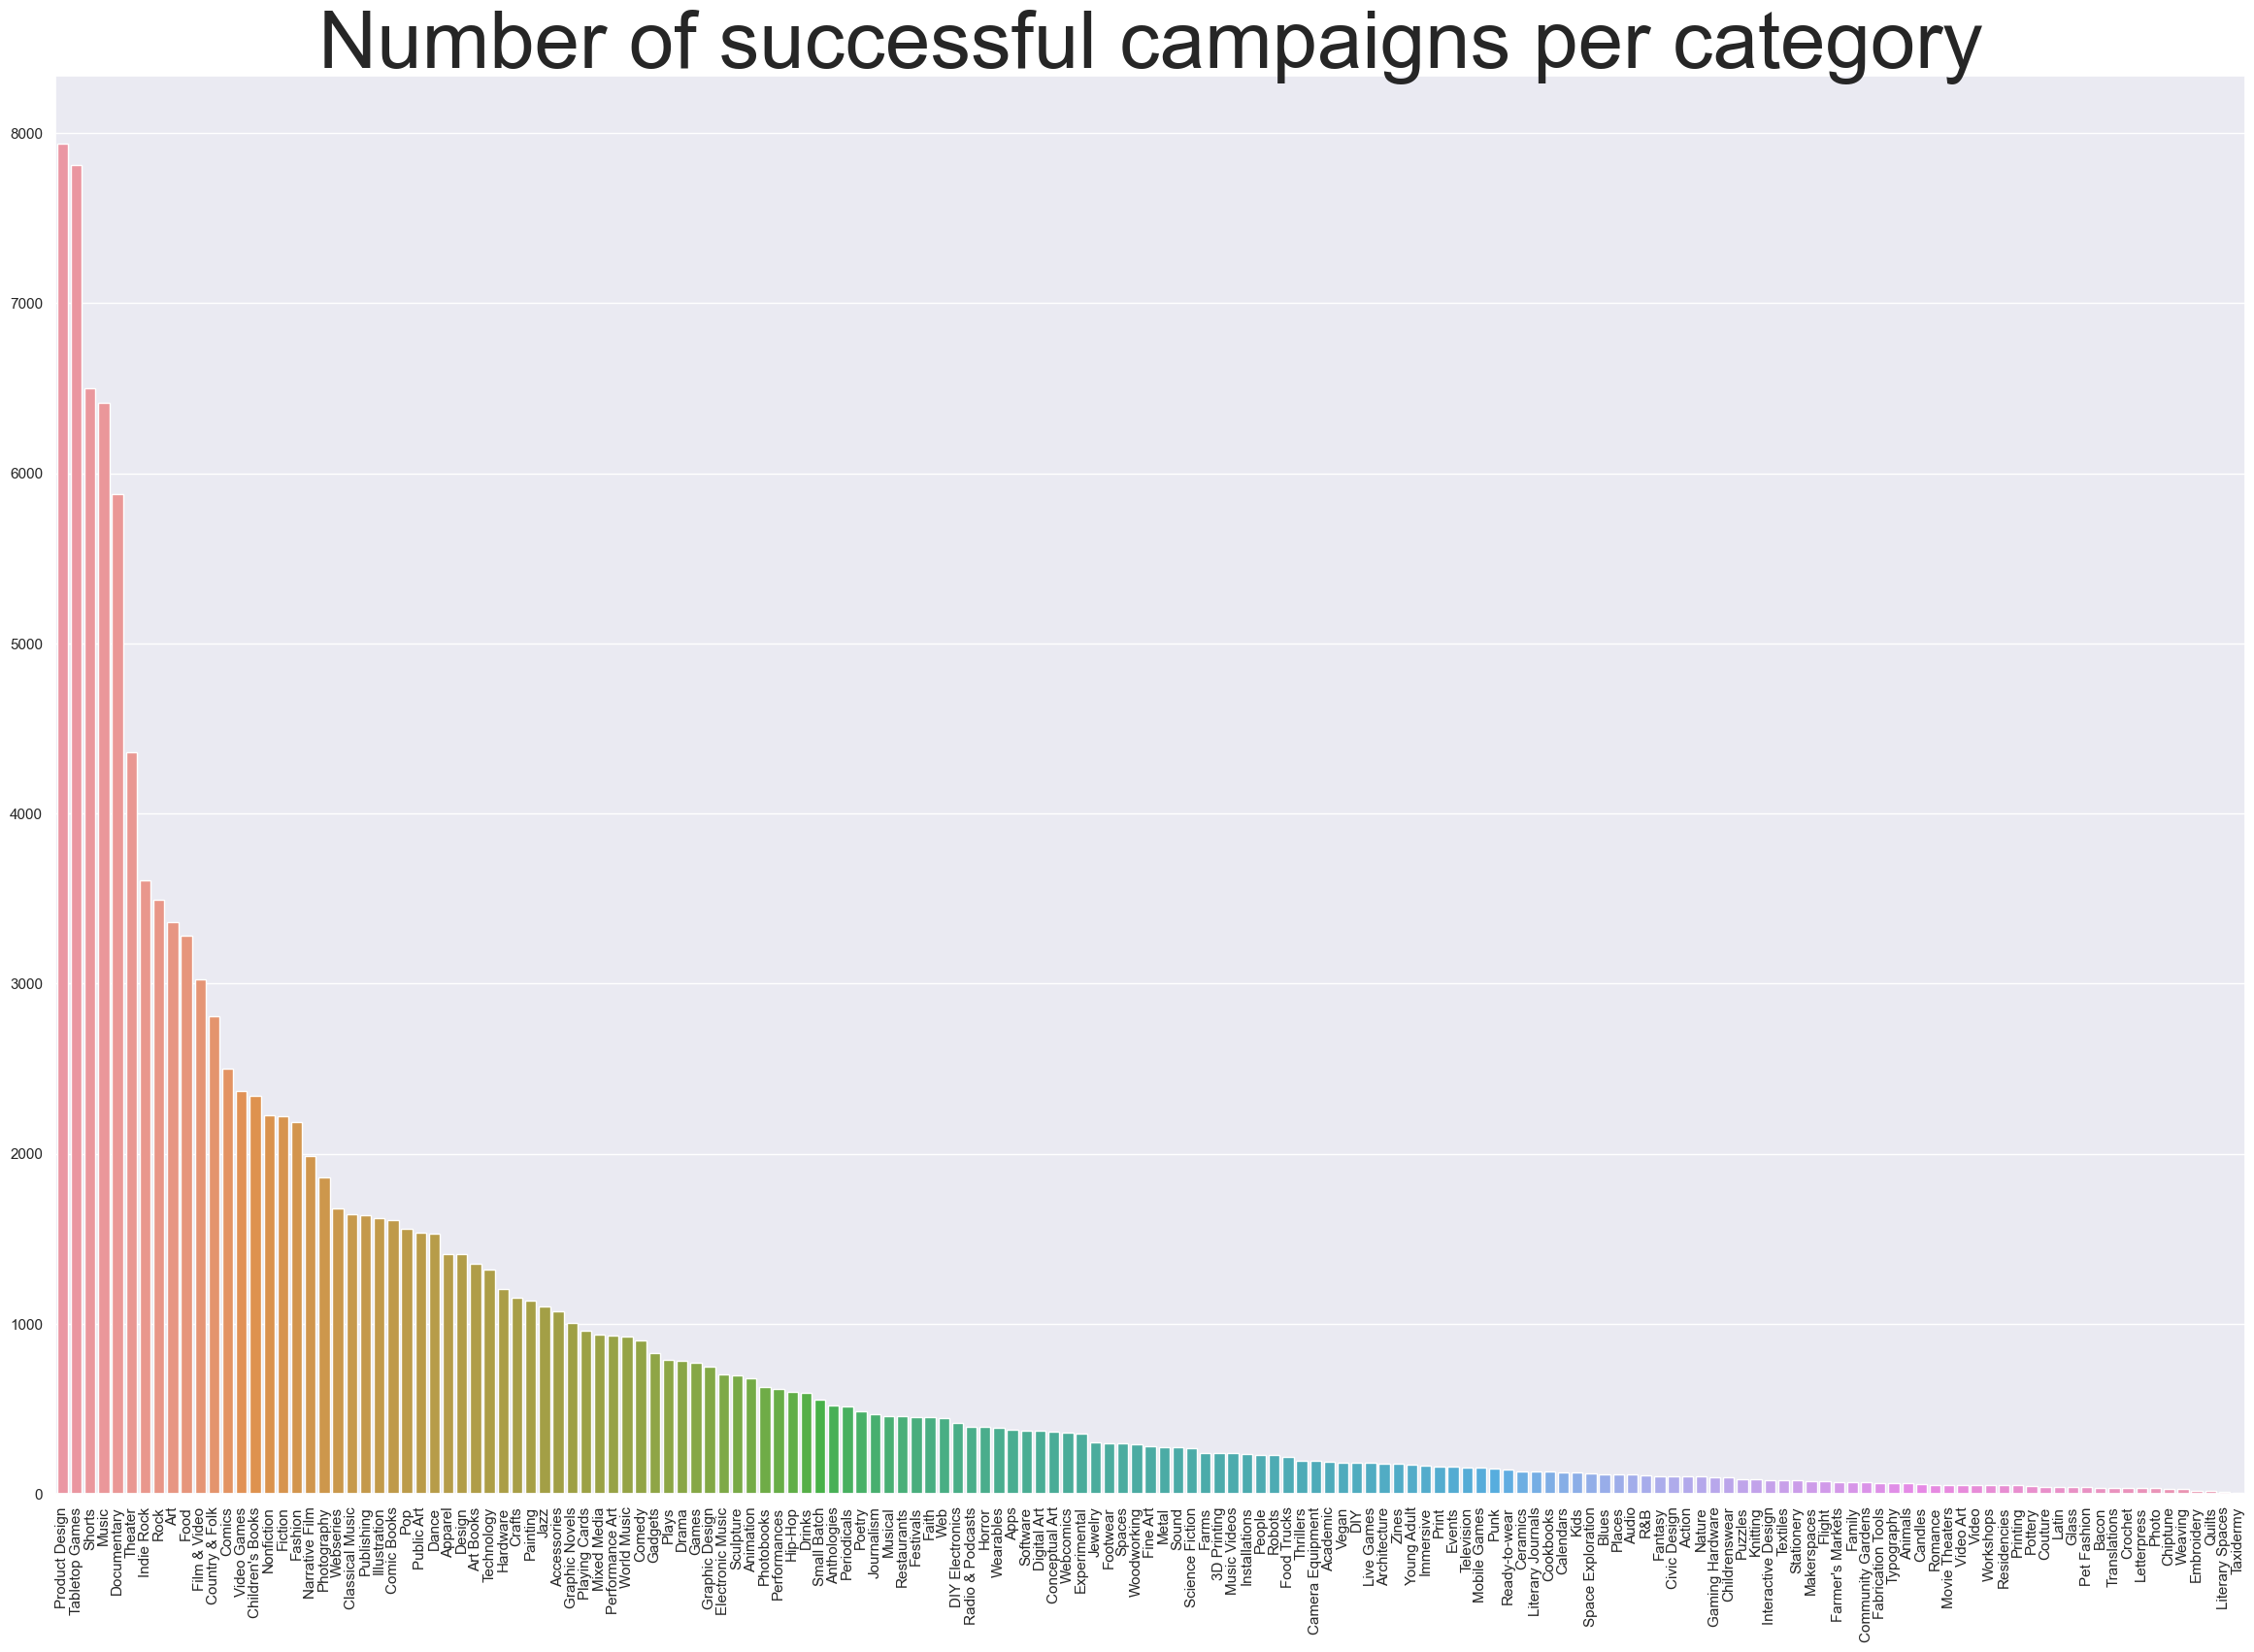

In [59]:
a4_dims = (23.4, 16.5)
fig, ax = plt.subplots(figsize=a4_dims)

sb.barplot(x=successful.category.value_counts().index,
                  y=successful.category.value_counts().values, ax=ax)

plt.xticks(rotation=90)
plt.tight_layout()
plt.title('Number of successful campaigns per category', fontsize=60)
plt.show()

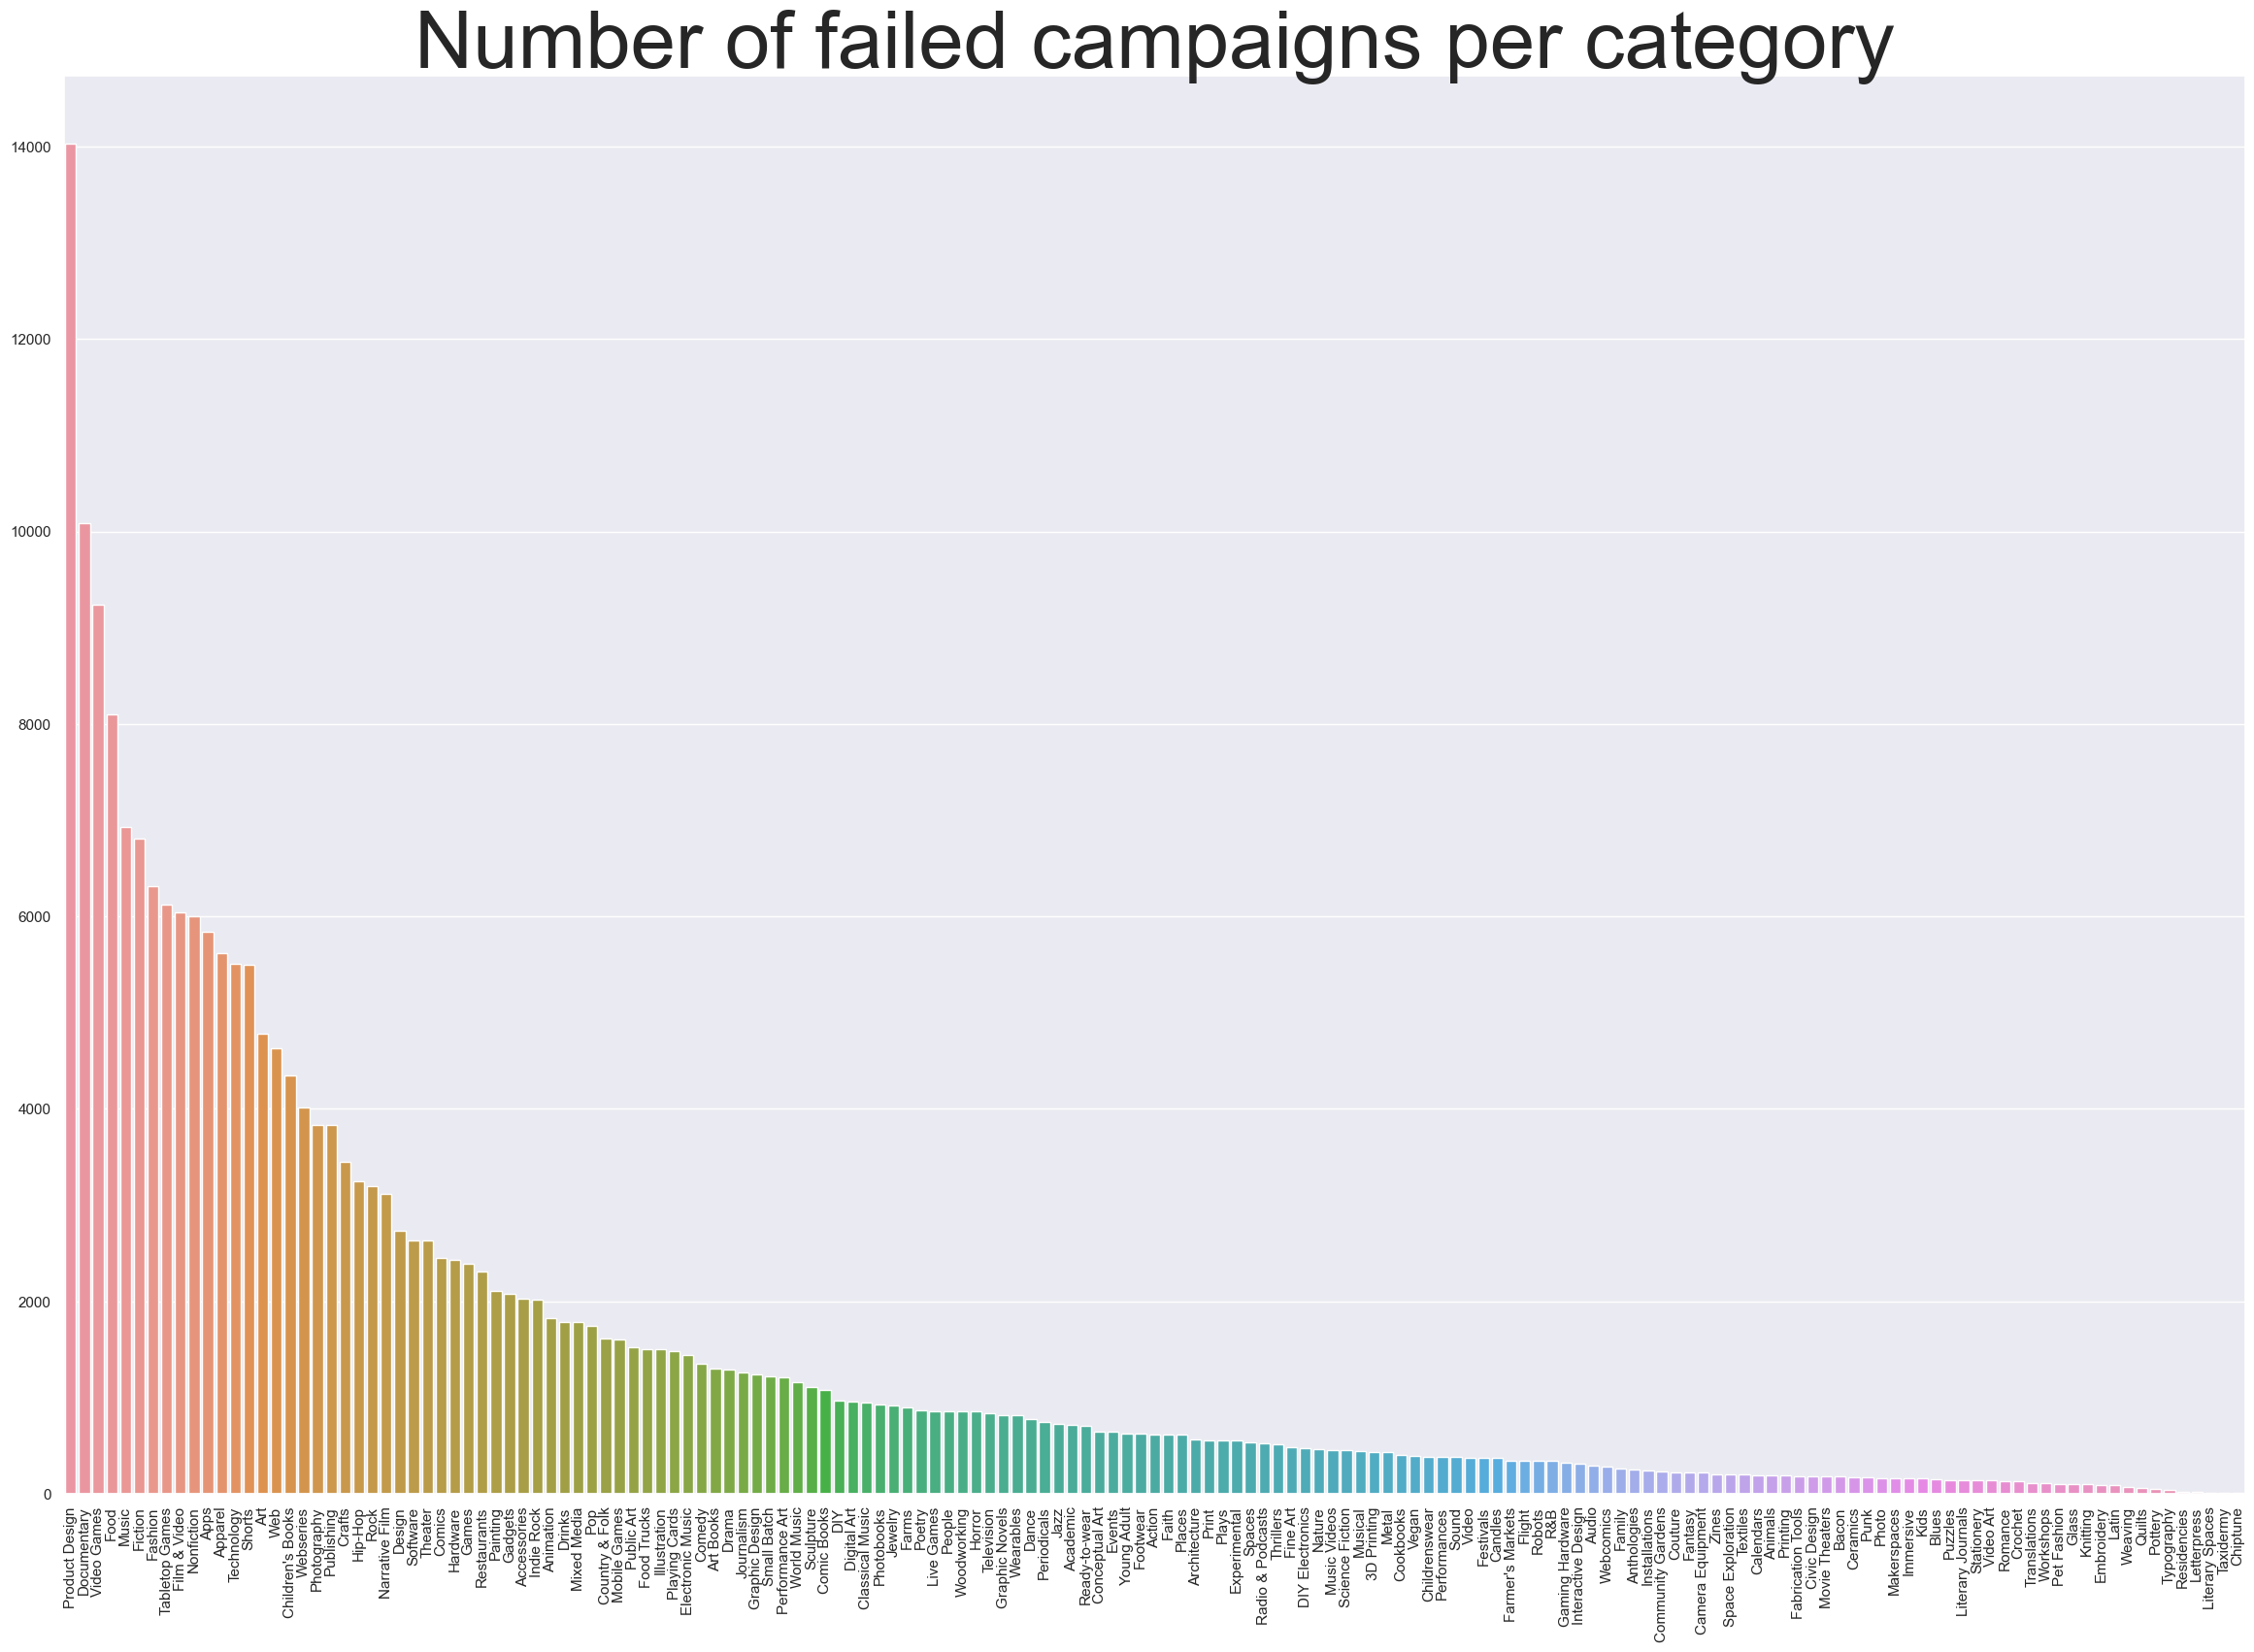

In [60]:
a4_dims = (23.4, 16.5)
fig, ax = plt.subplots(figsize=a4_dims)

sb.barplot(x=failed.category.value_counts().index,
                  y=failed.category.value_counts().values, ax=ax)

plt.xticks(rotation=90)
plt.tight_layout()
plt.title('Number of failed campaigns per category', fontsize=60)
plt.show()

In [56]:
cor = pd.DataFrame(clean_data, columns=['backers', 'usd_pledged_real', 'usd_goal_real', 'duration', 'launch_month', 'launch_year', 'name_length', 'pledge_per_backer'])
cor

,backers,usd_pledged_real,usd_goal_real,duration,launch_month,launch_year,name_length,pledge_per_backer
0,0,0.0,1533.95,58,8,2015,31,0.000000
1,15,2421.0,30000.00,59,9,2017,45,161.400000
2,3,220.0,45000.00,44,1,2013,14,73.333333
3,1,1.0,5000.00,29,3,2012,49,1.000000
4,14,1283.0,19500.00,55,7,2015,58,91.642857
...,...,...,...,...,...,...,...,...
378656,1,25.0,50000.00,29,9,2014,49,25.000000
378657,5,155.0,1500.00,26,6,2011,9,31.000000
378658,1,20.0,15000.00,45,7,2010,71,20.000000
378659,6,200.0,15000.00,30,1,2016,24,33.333333


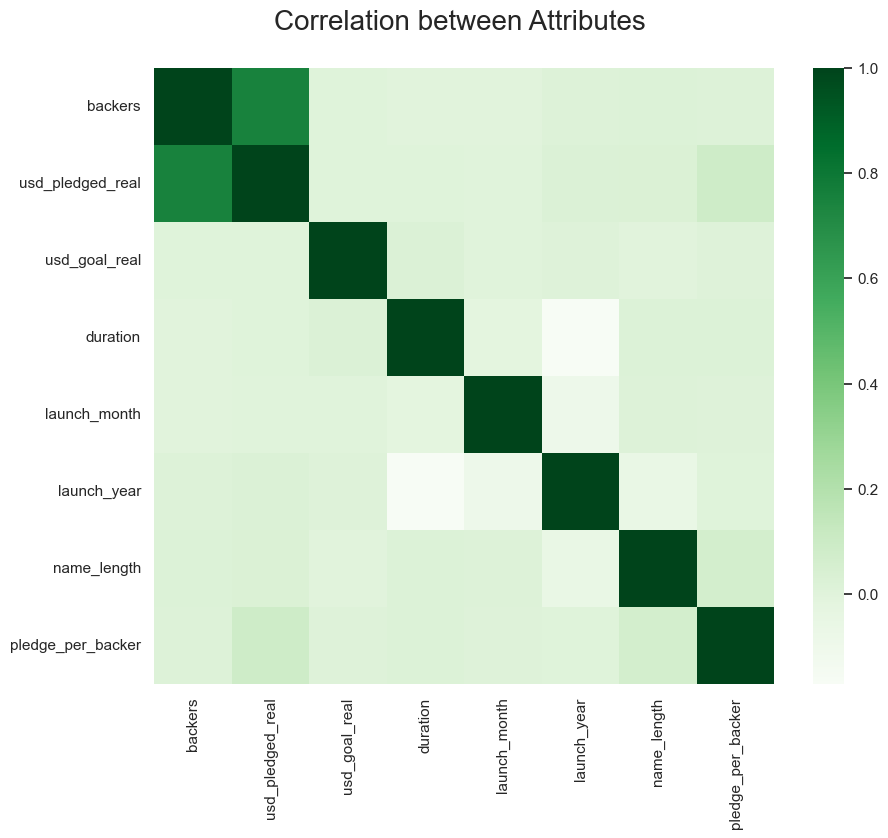

In [57]:
fig, ax = plt.subplots(figsize=(10,8))
sb.heatmap(cor.corr(), cmap='Greens',ax=ax)

plt.title('Correlation between Attributes \n', fontsize=20)
plt.show()

Heavy correlation exists between **backers** and **usd_pledged_real**

# Predictions

## Logistic Regression

Using our root problem statement, we want to have a good way of measuring the chances of a campaign failing or succeeding with the attributes from our dataset. We can see from the previous correlation heatmap, **backers** and **usd_pledged_real** are heavily correlated. 

We would also like to **usd_goal_real** and **duration** to our list of predictors as it would be intuitive for a first time investor to look at those attributes of a campaign before investing.

In [86]:
predictors = pd.DataFrame(clean_data, columns=['usd_goal_real', 'duration', 'backers', 'usd_pledged_real'])
X_train, X_test, y_train, y_test = train_test_split(predictors, clean_data['state'], test_size=0.2, random_state=3)

model = LogisticRegression()

model.fit(X_train, y_train)

score = model.score(X_test, y_test)
print('Accuracy:', score)

Accuracy: 0.9912716348430924


The accuracy is **99.13%**, which is very good. Thus, we can conclude that the following predictors are very useful in predicting a campaigns state.

failed        47125
successful    26772
Name: state, dtype: int64


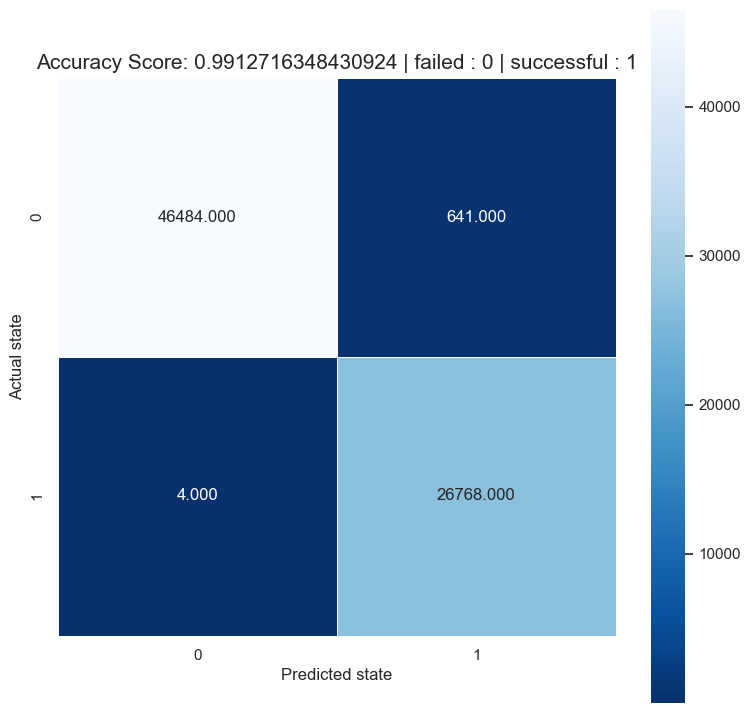

In [87]:
predictions = model.predict(X_test)

cm = metrics.confusion_matrix(y_test, predictions)
print(y_test.value_counts())

plt.figure(figsize=(9,9))
sb.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual state');
plt.xlabel('Predicted state');
all_sample_title = 'Accuracy Score: {0} | failed : 0 | successful : 1'.format(score)
plt.title(all_sample_title, size = 15);

## Linear Regression

Given the strong correlation between the variables **backers** and **usd_pledged_real** and their predictive power, we will employ linear regression to explore the relationship between these variables and identify any patterns.

This could be done as a part of EDA without the use of Linear Regression, but we have found that the Regression model helps us visualize it better.

In [89]:
fail = failed[failed.backers < 10000]
succ = successful[successful.backers < 10000]

The above is executed first to standardize the scales and limit the amount of outliers as there are a lot in this dataset,

### Failed Campaign Analysis

Intercept: [6.12934067]
Coefficient: [0.00809498]


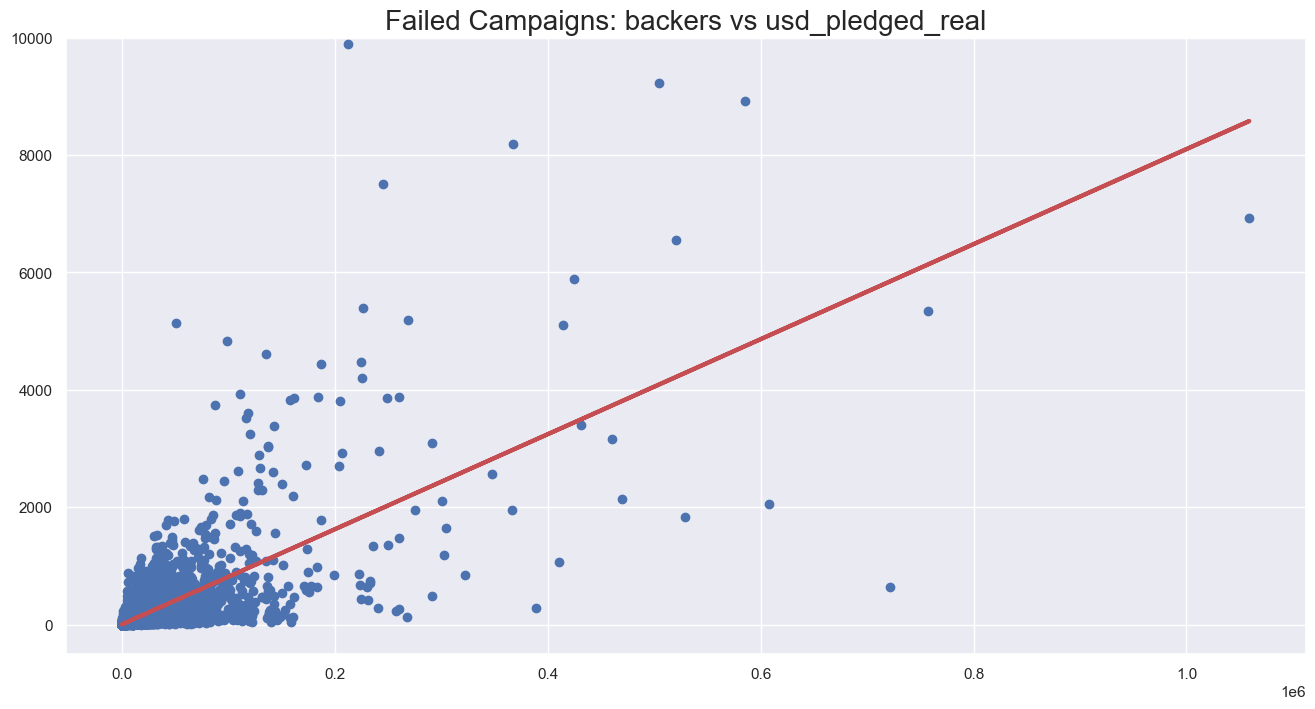

In [95]:
from sklearn.linear_model import LinearRegression

y = pd.DataFrame(fail['backers'])
X = pd.DataFrame(fail['usd_pledged_real'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

lr.fit(X_train, y_train)

regline_x = X_train
regline_y = lr.intercept_ + lr.coef_ * X_train

print("Intercept:", lr.intercept_)
print("Coefficient:", lr.coef_[0])

f, axes = plt.subplots(1, 1, figsize=(16, 8))
plt.scatter(X_train, y_train)
plt.plot(regline_x, regline_y, 'r-', linewidth = 3)
plt.title('Failed Campaigns: backers vs usd_pledged_real', fontsize=20)
plt.ylim(top=10000)
plt.show()

### Successful Campaign Analysis

Intercept: [114.29508982]
Coefficient: [0.00563004]


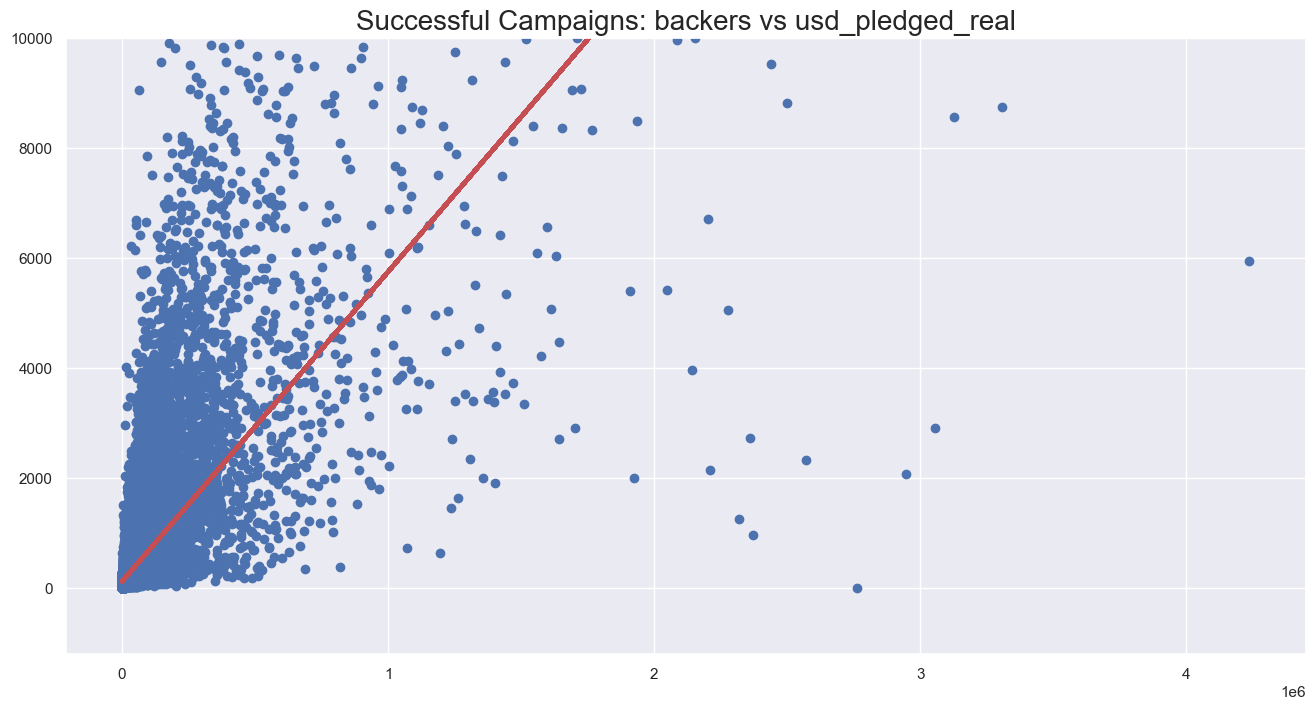

In [94]:
y = pd.DataFrame(succ['backers'])
X = pd.DataFrame(succ['usd_pledged_real'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

lr.fit(X_train, y_train)

regline_x = X_train
regline_y = lr.intercept_ + lr.coef_ * X_train

print("Intercept:", lr.intercept_)
print("Coefficient:", lr.coef_[0])

f, axes = plt.subplots(1, 1, figsize=(16, 8))
plt.scatter(X_train, y_train)
plt.plot(regline_x, regline_y, 'r-', linewidth = 3)
plt.title('Successful Campaigns: backers vs usd_pledged_real', fontsize=20)
plt.ylim(top=10000)
plt.show()

We noticed how the failed campaigns had a much lower slope than the successful campaigns, indicating that there were **less backers per pledged dollar** for failed campaigns as compared to a **higher backers per pledged dollar** for successful campaigns.

# Insight and Conclusion

Based on our analysis, the problem is a classification task. This involves using the selected predictors to predict which state a campaign is likely to head towards.

When combined with the Logistic Regression prediction model we can predict the state of a campaign using the following predictors:
- usd_goal_real
- duration
- backers
- usd_pledged_real

And for live campaigns, we can take the linear relation between **backers** and the current **usd_pledged_real** for an insight on whether the project is heading on a trajectory of a successful campaign or a failed one.

With successful campaigns having more backers that pledge less when compared to failed campaigns having less backers that pledge more money. This is also taken into account even with the total pledged amount for successful campaigns being ~3x that of the failed campaigns.

# Bias to note

There are Biases in this dataset which have to be take into account while looking at the predictions. The main one being the country of origin for these campaigns being primarily the United States.

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22],
 [Text(0, 0, 'GB'),
  Text(1, 0, 'US'),
  Text(2, 0, 'CA'),
  Text(3, 0, 'AU'),
  Text(4, 0, 'NO'),
  Text(5, 0, 'IT'),
  Text(6, 0, 'DE'),
  Text(7, 0, 'IE'),
  Text(8, 0, 'MX'),
  Text(9, 0, 'ES'),
  Text(10, 0, 'SE'),
  Text(11, 0, 'FR'),
  Text(12, 0, 'NL'),
  Text(13, 0, 'NZ'),
  Text(14, 0, 'CH'),
  Text(15, 0, 'AT'),
  Text(16, 0, 'DK'),
  Text(17, 0, 'BE'),
  Text(18, 0, 'HK'),
  Text(19, 0, 'LU'),
  Text(20, 0, 'N,0"'),
  Text(21, 0, 'SG'),
  Text(22, 0, 'JP')])

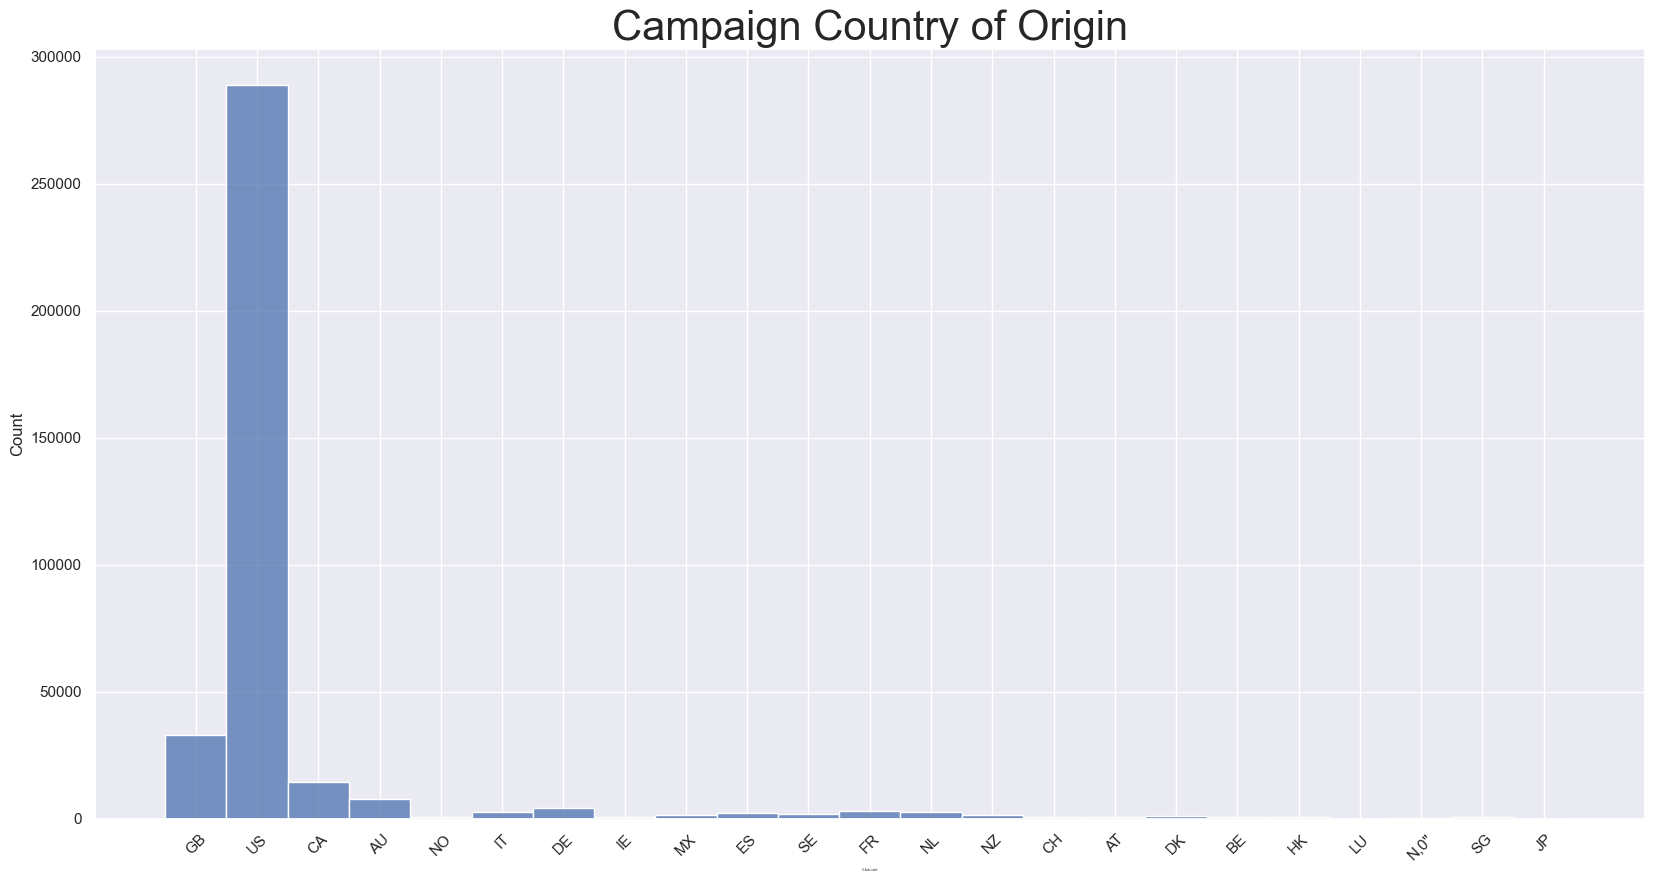

In [101]:
sb.histplot(data = clean_data['country'])
plt.xlabel('X-Axis Label' ,fontsize=2)
plt.title('Campaign Country of Origin', fontsize=30)
plt.xticks(rotation=45)